# Deletion Vectors and Reor Table

In [ ]:
# Generate dummy data

from pyspark.sql.functions import expr, lit, col, dayofmonth
from pyspark.sql.types import *
from datetime import date


df = spark.range(100) \
  .selectExpr("if(id % 2 = 0, 'Open', 'Close') as action") \
  .withColumn("date", expr("cast(concat('2023-06-', cast(rand(5) * 9 as int) + 1) as date)")) \
  .withColumn("device_id", expr("cast(rand(5) * 5 as int)")) \
  .withColumn("day", dayofmonth("date"))

delta_table_name = 'demo.deletion_vector_demo'
spark.sql(f"DROP TABLE IF EXISTS {delta_table_name}")


df.write.format("delta").partitionBy("day").mode("overwrite").saveAsTable(delta_table_name)

In [ ]:
%%sql
SHOW TBLPROPERTIES demo.deletion_vector_demo

## File storage

Have a look at the file storage - You can navegate through the lakehouse

├── _delta_log

│   └── 00000000000000000000.json

├── day=0

│   └── part-00000-805a80ba-1086-4ecd-97eb-d7ff92359f13.c000.snappy.parquet

├── day=1

│   └── part-00000-0e02935c-f84d-4b8a-ae09-db76f74a44ff.c000.snappy.parquet

├── day=2, day=3, etc...

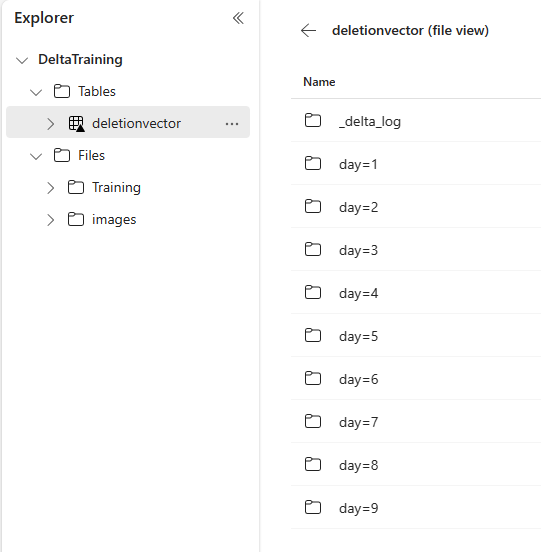
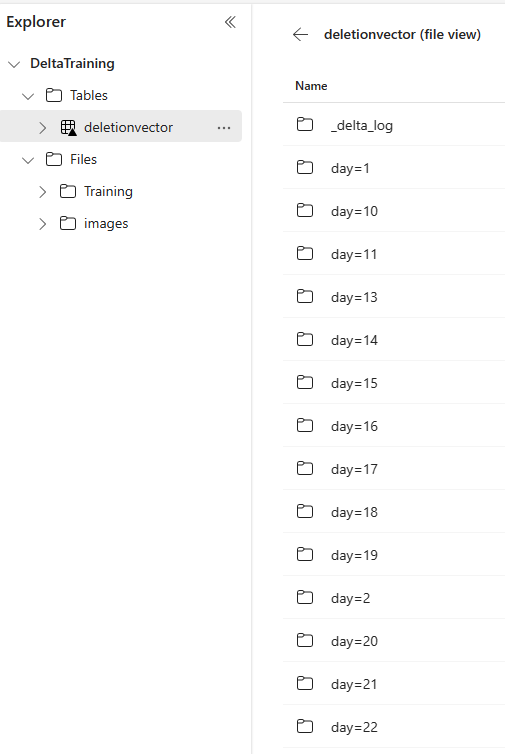

In [ ]:
path = 'Tables/deletion_vector_demo/'
files = mssparkutils.fs.ls(path)
for file in files:
    print(file.name, file.isDir, file.isFile, file.path, file.size)

> The traditional **copy-on-write** mode produces new Parquet data files in each partition. In other words, to delete a device id, we need to rewrite the entire partition table or in some cases the entire table!

In [ ]:
%%sql
DELETE FROM demo.deletion_vector_demo WHERE device_id = 2

> Look at OneLake and Delta Log

In [ ]:
deltalog = spark.read.json("Tables/deletion_vector_demo/_delta_log/00000000000000000001.json")
display(deltalog)

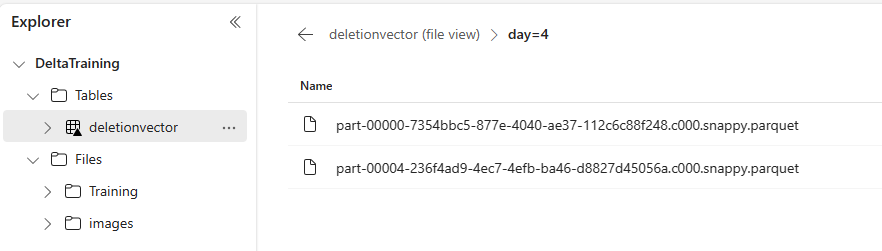

## Les's play with deletion vector

In [ ]:
# Generate dummy data

df = spark.range(100) \
  .selectExpr("if(id % 2 = 0, 'Open', 'Close') as action") \
  .withColumn("date", expr("cast(concat('2023-06-', cast(rand(5) * 9 as int) + 1) as date)")) \
  .withColumn("device_id", expr("cast(rand(5) * 5 as int)")) \
  .withColumn("day", dayofmonth("date"))


delta_table_name = 'demo.deletion_vector_demo'
spark.sql(f"DROP TABLE IF EXISTS {delta_table_name}")

df.write.format("delta").partitionBy("day").mode("overwrite").saveAsTable(delta_table_name)

In [ ]:
%%sql
SHOW TBLPROPERTIES demo.deletion_vector_demo

In [ ]:
%%sql
ALTER TABLE demo.deletion_vector_demo SET TBLPROPERTIES ('delta.enableDeletionVectors' = true);

In [ ]:
%%sql
SHOW TBLPROPERTIES demo.deletion_vector_demo

In [ ]:
%%sql
DELETE FROM demo.deletion_vector_demo WHERE device_id = 2

> Look at lakehouse explorer

In [ ]:
deltalog = spark.read.json("Tables/deletion_vector_demo/_delta_log/00000000000000000002.json")
display(deltalog)

_**Remove column**_

```
{   
    "path": "day=5/part-00003-7a25aeac-51ef-4699-931c-c9c6e426a909.c000.snappy.parquet",
    "size": 1659,
    "tags": {
        "VORDER": "true"
    },
    "dataChange": true,
    "partitionValues": {
        "day": "5"
    },
    "extendedFileMetadata": true,
    "deletionTimestamp": 1699029713915

}
```

In [ ]:
display(deltalog.select("remove.path", "remove.deletionTimestamp", "remove.dataChange", "remove.extendedFileMetadata","remove.partitionValues" ,"remove.size").where("remove is not null"))

_**Add colunm**_

```
{
    "stats": "{\"numRecords\":9,\"minValues\":{\"action\":\"Close\",\"date\":\"2023-06-04\",\"device_id\":1},\"maxValues\":{\"action\":\"Open\",\"date\":\"2023-06-04\",\"device_id\":2},\"nullCount\":{\"action\":0,\"date\":0,\"device_id\":0},\"tightBounds\":false}",
    "path": "day=4/part-00005-951841c8-1ceb-44a7-b466-896db9f32bd3.c000.snappy.parquet",
    "size": 1664,
    "tags": {
        "VORDER": "true"
    },
    "modificationTime": 1699029668153,
    "dataChange": true,
    "partitionValues": {
        "day": "4"
    },
    "deletionVector": {
        "cardinality": 5,
        "storageType": "u",
        "offset": 1,
        "sizeInBytes": 42,
        "pathOrInlineDv": ":FrA]E*!=uZR!LaI7[yo"
    }
}
```

> Pay attention to the nested descriptor object with the key **deletion_vector_demo**, that has metadata to help the reader correctly process the Deletion Vector.

In [ ]:
display(deltalog.select("add.path", "add.deletionVector", "add.dataChange", "add.modificationTime","add.partitionValues" ,"add.size").where("add is not null"))

In [ ]:
%%sql
DESCRIBE DETAIL demo.deletion_vector_demo

## Reorg

In [ ]:
%%sql
REORG TABLE demo.deletion_vector_demo APPLY (PURGE);


In [ ]:
%%sql

REORG TABLE demo.deletion_vector_demo WHERE day >= '04' APPLY (PURGE);

> Look at lakehouse explorer

## Vacuum

In [ ]:
spark.conf.set('spark.databricks.delta.retentionDurationCheck.enabled', 'false')

In [ ]:
%%sql
ALTER TABLE demo.deletion_vector_demo SET TBLPROPERTIES ('delta.deletedFileRetentionDuration'='interval 0 hour')

In [ ]:
%%sql

VACUUM demo.deletion_vector_demo 

> Look at lakehouse explorer again

# Clean up

In [ ]:
spark.sql(f"DROP TABLE IF EXISTS {delta_table_name}")